# Bot 

In [ ]:

import logging
from telegram import Update, Bot
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

bot = Bot(token=API_TOKEN)
updater = Updater(token=API_TOKEN, use_context=True)
dispatcher = updater.dispatcher

logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                     level=logging.INFO)


def send_new_channel_messages(update: Update, context: CallbackContext):
    channel_id = 'my life'
    channel_updates = bot.get_chat_updates(channel_id)

    user_id = update.message.from_user.id

    for update in channel_updates:
        if update.message:
            bot.forward_message(chat_id=user_id, from_chat_id=channel_id, message_id=update.message.message_id)


def start(update: Update, context: CallbackContext):
    user_id = update.message.from_user.id
    update.message.reply_text(f"Hello! I will send you new messages from the channel.")


def main():
    dispatcher.add_handler(MessageHandler(Filters.chat_type.channel, send_new_channel_messages))
    dispatcher.add_handler(CommandHandler("start", start))

    updater.start_polling()
    updater.idle()


if __name__ == '__main__':
    main()

# Config upload

In [1]:
import configparser
import json

from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError

In [2]:

config = configparser.ConfigParser()
config.read("config.ini")

api_id = config['Telegram']['api_id']
api_hash = config['Telegram']['api_hash']
api_token = config['Telegram']['api_token']

api_hash = str(api_hash)

phone = config['Telegram']['phone']
username = config['Telegram']['username']
channel_link = config['Telegram']['channel_link'] 

db_name = config['database']['db_name']
db_user = config['database']['db_user']
db_password = config['database']['db_password'] 
db_host = config['database']['db_host'] 


In [3]:
from transformers import pipeline


#facebook_bart_large_mnli = pipeline("zero-shot-classification", model="/media/tonyalpha/HDD/facebook-bart-large-mnli")
#bertweet_base_sentiment_analysis = pipeline("text-classification", model="/media/tonyalpha/HDD/bertweet-base-sentiment-analysis")

In [4]:
# if not client.is_user_authorized():
#     client.send_code_request(phone)
#     try:
#         client.sign_in(phone, input('Enter the code: '))
#     except SessionPasswordNeededError:
#         client.sign_in(password=input('Password: '))

# me = client.get_me()
# print(me)

# Get data from telegram 

In [5]:
from telethon.tl.types import InputMessagesFilterPhotos
from telethon import TelegramClient, events
import nest_asyncio

nest_asyncio.apply()

import os.path

def get_posts(num_posts = 1, download_media = False, only_with_media = True, offset_id = 0, posts_list = []):
    client = TelegramClient(username, api_id, api_hash)
    posts_list = []
    async def main(num_posts, download_media, offset_id, posts_list):
        
        if num_posts < 100:
            message_limit = num_posts
        else:
            message_limit = 100
            
            
        last_post_date = None
        post = {}
        
        await client.start()

        try:
            entity = await client.get_entity(channel_link)

            while True:
                messages = await client.get_messages(entity, limit=message_limit, offset_id = offset_id)

                for message in messages:
                    
                    if only_with_media:
                        if not message.media:
                            continue
                    
                    if last_post_date == None:
                        last_post_date = message.date

                    # if delay between uploading messages is more than 10 second i will separate them
                    if (last_post_date - message.date).seconds > 10: 
                        post['upload_date'] = last_post_date.strftime('%Y-%m-%d %H:%M:%S') if last_post_date else None

                        last_post_date = message.date

                        posts_list.append(post)
                        post = {}


                    if len(message.message) > 0:
                        post['text'] = post.get('text', '') + message.message 
                        
                        # post_id in messages set will be id of message with text and photo 
                        post['post_id'] = message.id


                    if message.media and download_media:

                        photo_id = message.media.photo.id
                        filename = f'image_{photo_id}.jpg'
                        path = f"./media/{filename}"

                        # some of this i should drop, but later 
                        post['photos_id_list'] = post.get('photos_id_list', []) + [photo_id]
                        post['photos_names_list'] = post.get('photos_names_list', []) + [filename]

                        #if file exist check 
                        if not os.path.isfile(path) and download_media:
                            await client.download_media(message, file=path)

                    post['id_list'] = post.get('id_list', []) + [message.id]
                    post['edit_date'] = message.edit_date.strftime('%Y-%m-%d %H:%M:%S') if message.edit_date else None


                offset_id = messages[len(messages) - 1].id

                if len(posts_list) >= num_posts:
                    break


        except Exception as e:
            print(f"Error: {e}")

        await client.disconnect()
        
        return posts_list

    if __name__ == "__main__":
        client.loop.run_until_complete(main(num_posts, download_media, offset_id, posts_list))
        
    return posts_list

# Data parsing

In [6]:
import re 

def parse_text(dct):
    
    input_string = dct.get('text', None)
    
    if input_string is None:
        return dct
    
    date_pattern = r'\d{2}\.\d{2}\.\d{2}'
    day_pattern = r'\b(?:MONDAY|TUESDAY|WEDNESDAY|THURSDAY|FRIDAY|SATURDAY|SUNDAY)\b'
    
    date_match = re.search(date_pattern, input_string)
    day_match = re.search(day_pattern, input_string)
    
    date = date_match.group() if date_match else None
    day = day_match.group() if day_match else None
    
    parsed_date = date.split('.')[-1] + '-' + date.split('.')[1] + '-' + date.split('.')[0] if date or day else None
    
    dct['parsed_date'] = parsed_date
    
    if date_match:
        input_string = input_string.replace(date_match.group(), "") if parsed_date is not None else input_string
    if day_match:
        input_string = input_string.replace(day_match.group(), "") if parsed_date is not None else input_string
    
    regex_list = [r'How productive have you been\?:\s*(\S|\s+|\d+\.?\d*)/10', r'How interesting was the day\?:\s*(\S|\s+|\d+\.?\d*)/10', r'How stressful was the day\?:\s*(\S|\s+|\d+\.?\d*)/10']
    names_list = ['productivity_score', 'interest_score', 'stress_score']
    
    for regex, name in zip(regex_list, names_list):
        match = re.search(regex, input_string)
        
        if match:
            try:
                parsed_score = float(match.group(1))
            except:
                parsed_score = None
        else:
            parsed_score = None
        
        
        #parsed_score = match.group(1) if match and match.group(1).isdigit() else None
        
        dct[name] = parsed_score

        input_string = input_string.replace(match.group(), "") if match else input_string
        
    
    dct['parsed_text'] = input_string.split('\n')
    return dct
    
def parse_activities(dct):
    
    input_list = dct.get('parsed_text', None)
    
    if input_list is None:
        return dct
    
    result = []
    for item in input_list:
        match = re.match(r'^([\U0001F000-\U0001F9FF]+|[\U0001FA00-\U0001FA6F]+|\*)?\s*(.*)$', item)
        if match:
            emoji = match.group(1)
            text = match.group(2).strip()
            if emoji or text:
                result.append((emoji, text))
                
    dct['parsed_activities'] = result
    return dct

# Upload to DB 

In [7]:
        
def update_post(post_id, update_data):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            update_post_table_query= ''
            update_values = []
            
            for key, value in update_data.items():
                    update_post_table_query += key + ' = %s, '
                    update_values += [value]
            
            update_post_table_query = update_post_table_query.rstrip(', ')
            update_post_table_query = 'UPDATE posts SET ' + update_post_table_query + ' WHERE post_id = %s;'
            
            update_values += [post_id]
            update_values = tuple(update_values)
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(update_post_table_query, update_values)
                connection.commit()
                
            print(f'UPDATED: post with id:{post_id}')
    except Error as e:
        print(e)

        
                
def update_activity(activity_id, update_data):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            update_activity_table_query= ''
            update_values = []
            
            for key, value in update_data.items():
                    update_activity_table_query += key + ' = %s, '
                    update_values += [value]
            
            update_activity_table_query = update_activity_table_query.rstrip(', ')
            update_activity_table_query = 'UPDATE activities SET ' + update_activity_table_query + ' WHERE activity_id = %s;'
            
            update_values += [activity_id]
            update_values = tuple(update_values)
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(update_activity_table_query, update_values)
                connection.commit()
                
            print(f'UPDATED: activity with id:{activity_id}')
    except Error as e:
        print(e)

In [8]:
import mysql.connector

from getpass import getpass
from mysql.connector import connect, Error


def db_connect():
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            create_posts_table_query = """
            CREATE TABLE IF NOT EXISTS posts(
                post_id INT,
                text TEXT,
                parsed_date DATE,
                upload_date DATETIME,
                edit_date DATETIME, 
                productivity_score FLOAT,
                interest_score FLOAT,
                stress_score FLOAT,
                predicted_productivity_score FLOAT,
                predicted_interest_score FLOAT,
                predicted_stress_score FLOAT,
                PRIMARY KEY (post_id)
            );
            """
            
            create_posts_table_activities = """
            CREATE TABLE IF NOT EXISTS activities(
                activity_id INT AUTO_INCREMENT,
                post_id INT,
                activity_name TEXT,
                activity_emoji TEXT,
                activity_type TEXT,
                activity_emotion TEXT,
                predicted_activity_type TEXT,
                predicted_activity_emotion TEXT,
                FOREIGN KEY (post_id) REFERENCES posts(post_id),
                PRIMARY KEY (activity_id)
            );
            """
            
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(create_posts_table_query)
                cursor.execute(create_posts_table_activities)
                connection.commit()
    except Error as e:
        print(e)
        
def upload_post(dct, overwrite = False):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            check_if_exist = """SELECT EXISTS(SELECT 1 FROM posts WHERE post_id = %s LIMIT 1)"""
            
            upload_posts_table_query = f"""
            INSERT INTO posts (post_id, text, parsed_date, upload_date, 
            edit_date,productivity_score, interest_score, stress_score, 
            predicted_productivity_score, predicted_interest_score,
            predicted_stress_score) 
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            
            post_id = (dct.get('post_id', None),)
            uploaded_date = dct.get('upload_date', None)
            
            insert_data = (dct.get('post_id', None), dct.get('text', None), 
                    dct.get('parsed_date', None), dct.get('upload_date', None), 
                    dct.get('edit_date', None),dct.get('productivity_score', None),
                    dct.get('interest_score', None),dct.get('stress_score', None),
                    dct.get('predicted_productivity_score', None), dct.get('predicted_interest_score', None),
                    dct.get('predicted_stress_score', None))
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(check_if_exist, post_id)
                for el in cursor:
                    exist = el[0]
                
                if not exist:
                    cursor.execute(upload_posts_table_query, insert_data)
                    connection.commit()
                    print(f'UPLOADED: post with id:{post_id} and uploaded_date:{uploaded_date}')
                else:
                    if overwrite:
                        pass
                        print('OVERWRITED: post with id:{post_id} and uploaded_date:{uploaded_date}')
                    else:
                        print(f'ERROR: post with id:{post_id} and uploaded_date:{uploaded_date} already uploaded')
                        print('If you want to overwrite data add flag')
    except Error as e:
        print(e)
        
        
def upload_activities(dct, overwrite = False):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            for activity_emoji, activity_name in dct['parsed_activities']:
                
                # add or not? 
                #if activity_emoji == '*' or activity_emoji == '📦':
                #   continue
                
                activity_name = "".join(c for c in activity_name if c.isalpha() or c.isnumeric() or c == ' ' or c == '!').strip(' ')
                check_if_exist = """SELECT EXISTS(SELECT 1 FROM activities WHERE post_id = %s AND activity_name = %s LIMIT 1)"""

                upload_posts_table_query = f"""
                INSERT INTO activities (post_id, activity_name, activity_emoji, activity_type, 
                activity_emotion, predicted_activity_type, predicted_activity_emotion) 
                VALUES(%s, %s, %s, %s, %s, %s, %s)
                """
                post_id = dct.get('post_id', None)
                
                check_data = (post_id, activity_name)

                insert_data = (dct.get('post_id', None), activity_name, 
                              activity_emoji, dct.get('activity_type', None), dct.get('activity_emotion', None),
                              dct.get('predicted_activity_type', None), dct.get('predicted_activity_emotion', None))
            
                with connection.cursor() as cursor:
                    cursor.execute(use_db_query)
                    cursor.execute(check_if_exist, check_data)
                    for el in cursor:
                        exist = el[0]

                    if not exist:
                        cursor.execute(upload_posts_table_query, insert_data)
                        connection.commit()
                        print(f'UPLOADED: activity with post_id:{post_id} and activity_name:{activity_name}')
                    else:
                        # add overwrite option
                        print(f'ERROR: activity with post_id:{post_id} and activity_name:{activity_name} already uploaded')
    except Error as e:
        print(e)
        
        
def update_post(dct):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            update_posts_table_query = """
            UPDATE posts SET text = %s, parsed_date = %s,  
            upload_date = %s, edit_date = %s, productivity_score = %s,
            interest_score = %s, stress_score = %s WHERE post_id = %s
            """
            
            data = (dct.get('text', None), 
                    dct.get('parsed_date', None), dct.get('upload_date', None), 
                    dct.get('edit_date', None),dct.get('productivity_score', None),
                    dct.get('interest_score', None),dct.get('stress_score', None),
                   dct.get('post_id', None))

            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(update_posts_table_query, data)
                connection.commit()
    except Error as e:
        print(e)

def db_show_tables():
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            show_tables = "SHOW TABLES;"
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(show_tables)
                for el in cursor.fetchall():
                    print(el)
    except Error as e:
        print(e)
        
def db_execute_query(query, commit = False):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(query)
                if commit:
                    connection.commit()
                for el in cursor:
                    print(el)
    except Error as e:
        print(e)

In [9]:
db_connect()

In [10]:
db_show_tables()

('activities',)
('posts',)


In [11]:
db_execute_query('SELECT activity_id FROM activities WHERE post_id = 721 AND activity_name = "Hiking with Ann" LIMIT 1')

(9,)


In [124]:
# db_execute_query('DELETE FROM posts WHERE post_id > 0;', commit = True)

In [131]:
# db_execute_query('DROP TABLE posts;', commit = True)

In [12]:
db_execute_query('SELECT * FROM activities WHERE post_id = 135')

In [50]:
# db_execute_query('DELETE FROM posts WHERE post_id = 135', commit = True)

In [262]:
update_activity(9, {'activity_name': 'Hiking with Ann'})

UPDATED: activity with id:9


In [137]:
db_execute_query('SELECT * FROM posts WHERE post_id = 316')

(316, '15.04.24\n\n💪🏻🥊 Sport: martial art\n\n📚 DL lecture\n📚DL: hm\n\n👩\u200d👦💬 Talk with mother \n\n\n📦 Optics: lecture \n📦 Tinkoff hm\n📦 Tinkoff work \n📦 Reading: Harry Potter and methods of rationality\n\nHow productive have you been?: 6/10\nHow interesting was the day?: 6/10\nHow stressful was the day?: 0/10', datetime.date(2024, 4, 15), datetime.datetime(2023, 4, 15, 14, 6, 38), datetime.datetime(2023, 7, 26, 15, 12, 44), 6.0, 6.0, 0.0, None, None, None)


In [29]:
db_execute_query('SELECT * FROM activities WHERE activity_name LIKE \'Write people about specialization\'')

(244, 422, 'Write people about specialization', None, 'social_&_friends', None, None, None)


In [ ]:
update_activity(244, {'activity_name': 'Hiking with Ann'})

In [74]:
import datetime

datetime.date(2026, 7, 23).year

2026

# Main

In [15]:
def check_post(post):
    
    date = post.get('upload_date', None)
    
    if post.get('text', None) is None:
        print(f'I dont see any text, can you add it to post uploaded at {date}?')
        return False
    
    text = post.get('text', None)
    
    if post.get('parsed_date', None) is None:
        print(f'I dont see date, can you add it to post uploaded at {date} with text:{text}?')
        return False

    if post.get('productivity_score', None) is None:
        print(f'I dont see productivity_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
        
    if post.get('interest_score', None) is None:
        print(f'I dont see interest_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
        
    if post.get('productivity_score', None) is None:
        print(f'I dont see productivity_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
        
    if post.get('stress_score', None) is None:
        print(f'I dont see stress_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
    return True

def check_activities(post):
    
    date = post.get('upload_date', None)
    
    
    if post.get('parsed_activities', None) is None or len(post.get('parsed_activities', None)) < 0:
        print(f'I dont see activities, can you add some to post uploaded at {date}?')
        return False
    return True


In [162]:


posts = get_posts(num_posts = 1000)

for post in posts:
    post = parse_text(post)
    post = parse_activities(post)
    if check_post(post):
        upload_post(post, overwrite = False)
        if check_activities(post):
            upload_activities(post, overwrite = False)

In [161]:
print('fg')

fg


# Data markup

In [16]:
from IPython.display import clear_output

def markup_activities_type(activity_types):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            get_activities = '''SELECT * FROM activities WHERE activity_type is NULL'''    
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(get_activities)
                for el in cursor:
                    activity_id = el[0]
                    activity_name = el[2]
                    print('==============================================================================')
                    print(f'ACTIVITY NAME: {activity_name}')
                    #print('What type of activity this is?')
                    print('\n'.join([str(i) + ' - ' + activity_types[i-1] for i in range(1, len(activity_types) + 1)]))
                    type_num = input('SELECT ACTIVITY TYPE:')
                    
                    try:
                        activity_type = activity_types[int(type_num) - 1]
                        update_activity(activity_id, {'activity_type':activity_type})
                        clear_output(wait=False)
                    except Error as e:
                        print(f'ERROR: {e}')

    except Error as e:
        print(e)
        
        
def markup_activities_sentiment(activity_emotions):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            get_activities = '''SELECT * FROM activities WHERE activity_emotion is NULL'''    
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(get_activities)
                for el in cursor:
                    activity_id = el[0]
                    activity_name = el[2]
                    print('==============================================================================')
                    print(f'ACTIVITY NAME: {activity_name}')
                    #print('What type of activity this is?')
                    print('\n'.join([str(i) + ' - ' + activity_emotions[i-1] for i in range(1, len(activity_emotions) + 1)]))
                    emotion_num = input('SELECT ACTIVITY SENTIMENT:')
                    
                    try:
                        activity_emotion = activity_emotions[int(emotion_num) - 1]
                        update_activity(activity_id, {'activity_emotion':activity_emotion})
                        clear_output(wait=False)
                    except Error as e:
                        print(f'ERROR: {e}')

    except Error as e:
        print(e)

In [17]:
activity_types = ['self_development', 'university', 'work', 'relax_&_rest', 'chill', 'sport_&_health', 'family', 'social_&_friends', 'travel_&_adventure', 'chore', 'other']
encode_activity_type_dict = {activity_types[i]:i for i in range(len(activity_types))}

In [ ]:
markup_activities_type(activity_types)

In [18]:
activity_emotions = ['Positive', 'Negative', 'Neutral']
encode_emotion_dict = {activity_emotions[i]:i+1 for i in range(len(activity_emotions))}

In [114]:
markup_activities_sentiment(activity_emotions)

# SQL to Pandas 

In [20]:
import pandas as pd

def sql_to_df(table_name):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            show_activities = f"SELECT * FROM {table_name};"
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                df = pd.read_sql(show_activities, connection)
            return df         
    except Error as e:
        print(e)
        return None

In [70]:
activities_df = sql_to_df('activities')
activities_df.head(5)

,activity_id,post_id,activity_name,activity_emoji,activity_type,activity_emotion,predicted_activity_type,predicted_activity_emotion
0,9,721,Hiking with Ann,None,family,Neutral,None,None
1,10,721,Working on my project,None,self_development,Neutral,None,None
2,11,721,Gym,*,sport_&_health,Neutral,None,None
3,12,721,Interesting history lecture,*,relax_&_rest,Positive,None,None
4,13,718,Awesome cycling with Anna and her brother,None,family,Positive,None,None


In [84]:
activities_df = activities_df[['activity_id', 'post_id', 'activity_name', 'activity_emoji',
       'activity_type', 'activity_emotion']]

In [85]:
activities_df.sample(4)

,activity_id,post_id,activity_name,activity_emoji,activity_type,activity_emotion
268,277,406,Box,🥊,sport_&_health,None
337,346,336,Quantum mechanics hm,📝,university,None
29,38,663,Quick things packing and household chores,None,chore,None
8,17,715,My project for portfolio do some things,None,self_development,Neutral


In [72]:
activities_columns = ['activity_id', 'post_id', 'activity_name', 'activity_emoji',
       'activity_type', 'activity_emotion']

<AxesSubplot:xlabel='activity_type'>

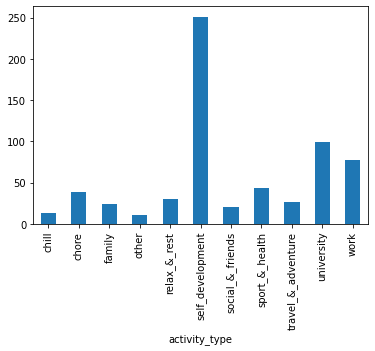

In [73]:
activities_df.groupby(by = ['activity_type']).activity_id.count().plot.bar()

In [103]:
activities_df.to_csv('activities_df_with_posts_id.csv')

In [101]:
posts_df.to_csv('posts_df.csv')

In [74]:
posts_df = sql_to_df('posts')
posts_df.head(5)
posts_df = posts_df.drop(columns = ['text'])

In [82]:
posts_df = posts_df[['post_id', 'parsed_date',
       'productivity_score', 'interest_score', 'stress_score']]

In [83]:
posts_df.sample(4)

,post_id,parsed_date,productivity_score,interest_score,stress_score
72,399,2023-05-09,5.5,6.0,0.0
10,142,2023-02-09,7.0,7.0,0.0
95,500,2023-06-08,4.5,4.0,2.0
105,546,2023-06-19,5.0,5.0,1.0


In [95]:
posts_df.sample(4)

,post_id,parsed_date,productivity_score,interest_score,stress_score
68,387,2023-05-05,6.0,6.0,2.0
67,377,2023-05-04,5.0,7.0,0.0
4,129,2023-01-31,7.0,7.0,1.0
21,170,2023-02-20,6.0,6.0,2.0


In [76]:
posts_columns = ['post_id', 'parsed_date', 'upload_date', 'edit_date',
       'productivity_score', 'interest_score', 'stress_score']

In [77]:
posts_df[['parsed_date', 'productivity_score', 'interest_score', 'stress_score']]

,parsed_date,productivity_score,interest_score,stress_score
0,2023-01-27,6.0,6.0,1.0
1,2023-01-28,4.0,4.0,3.0
2,2023-01-29,5.0,5.0,2.0
3,2023-01-30,7.0,7.0,1.0
4,2023-01-31,7.0,7.0,1.0
...,...,...,...,...
138,2023-07-22,5.0,3.0,0.0
139,2023-07-23,5.0,5.0,2.0
140,2023-07-24,4.5,5.0,0.0
141,2023-07-25,3.5,6.0,2.0


<AxesSubplot:>

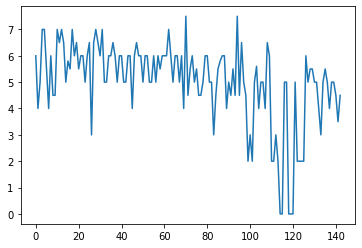

In [28]:
posts_df.productivity_score.plot()

<AxesSubplot:>

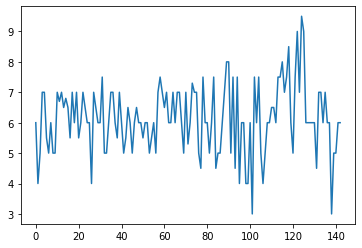

In [30]:
posts_df.interest_score.plot()

<AxesSubplot:>

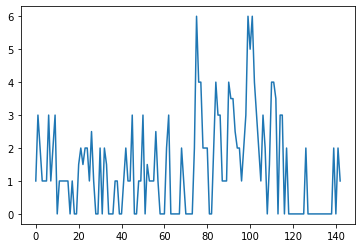

In [31]:
posts_df.stress_score.plot()

# Recsys

In [94]:
# !pip install xgboost -q

In [96]:
import pandas as pd
import fasttext
import torch
import torch.nn as nn

# Load pretrained FastText model
fasttext_path = '/content/drive/MyDrive/PROJECTS_COMPETITIONS/life_analyser/fasttext-en/model.bin'
ft_model = fasttext.load_model(fasttext_path)

# Sample activities_df and posts_df (replace with your actual data)


# Concatenate activities_df and posts_df by post_id
combined_df = pd.merge(posts_df, activities_df, on='post_id')

# Get FastText embeddings for activity names and sum them for each post
combined_df['activity_embeddings'] = combined_df['activity_name'].apply(lambda x: ft_model.get_sentence_vector(x))
activity_embeddings_sum = combined_df.groupby('post_id')['activity_embeddings'].apply(sum).reset_index()

# Sort the combined_df by parsed_date in descending order
combined_df['parsed_date'] = pd.to_datetime(combined_df['parsed_date'])
combined_df = combined_df.sort_values(by='parsed_date', ascending=False)



# Implement the RNN model
class WordRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WordRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Set up parameters for the RNN model
input_size = len(activity_embeddings_sum['activity_embeddings'][0])
hidden_size = 64
num_layers = 1
output_size = 32

# Initialize and set up the RNN model
model = WordRNN(input_size, hidden_size, num_layers, output_size)

# Convert activity embeddings to tensors
activity_embeddings_sum['activity_embeddings'] = activity_embeddings_sum['activity_embeddings'].apply(lambda x: torch.tensor(x, dtype=torch.float32))

# Create a sequence of activity embeddings for each post
post_sequences = []
for post_id, group in activity_embeddings_sum.groupby('post_id'):
    post_sequence = torch.stack(group['activity_embeddings'].tolist())
    post_sequences.append(post_sequence)

# Pad sequences to have the same length
padded_sequences = nn.utils.rnn.pad_sequence(post_sequences, batch_first=True)

# Forward pass through the model
with torch.no_grad():
    output = model(padded_sequences)

# Print the last hidden vector for each post
for post_id, hidden_vector in zip(activity_embeddings_sum['post_id'], output):
    print(f"Post ID: {post_id}, Last Hidden Vector: {hidden_vector}")


ModuleNotFoundError: No module named 'fasttext'

# Activity classification: fine-tune DistilBERT/RoBERTa base

In [19]:
activity_types = ['self_development', 'university', 'work', 'relax_&_rest', 'chill', 'sport_&_health', 'family', 'social_&_friends', 'travel_&_adventure', 'chore', 'other']

In [20]:
encode_activity_type_dict

{'self_development': 0,
 'university': 1,
 'work': 2,
 'relax_&_rest': 3,
 'chill': 4,
 'sport_&_health': 5,
 'family': 6,
 'social_&_friends': 7,
 'travel_&_adventure': 8,
 'chore': 9,
 'other': 10}

In [18]:
df = activities_df[['activity_name','activity_type']]
def encode_type(x):
    return encode_activity_type_dict[x]

In [21]:
df['encoded_activity_type'] = df['activity_type'].apply(lambda x: encode_type(x))

<ipython-input-21-82106bc8f75c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_activity_type'] = df['activity_type'].apply(lambda x: encode_type(x))


In [22]:
df

,activity_name,activity_type,encoded_activity_type
0,Hiking with Ann,family,6
1,Working on my project,self_development,0
2,Gym,sport_&_health,5
3,Interesting history lecture,relax_&_rest,3
4,Awesome cycling with Anna and her brother,family,6
...,...,...,...
631,still recovering from lack of sleep,relax_&_rest,3
632,Slept for 6 hours in the morning i have visite...,other,10
633,Statistics HM,self_development,0
634,Tinkoff HM first two tasks,self_development,0


In [23]:
df.to_csv('activities_df.csv')

In [233]:
random_state = 1337


def set_seed(seed=random_state):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    tf.random.set_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


In [234]:
import datetime
import time
import random
import os
import argparse

import pandas as pd
import numpy as np
import torch

from transformers import DistilBertModel, DistilBertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.cuda.amp import GradScaler, autocast

In [235]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-05
EPS =  1e-8
NUM_CLASSES = len(activity_types)

distilbert_path = '/media/tonyalpha/HDD/distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distilbert_path)

In [236]:
import torch

if torch.cuda.is_available():    
  
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [237]:
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.activity_type[index])
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.encoded_activity_type[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [238]:
#let's define max sentence len 

max_len = 0

for sent in df.activity_name:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  36


In [239]:
MAX_LEN = 64

In [240]:
set_seed()

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=random_state)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (636, 3)
TRAIN Dataset: (509, 3)
TEST Dataset: (127, 3)


In [241]:
set_seed()

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

train_loader = DataLoader(training_set, **train_params)
test_loader = DataLoader(testing_set, **test_params)

In [242]:
class DistillBERT_classifier(torch.nn.Module):
    def __init__(self):
        super(DistillBERT_classifier, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(distilbert_path)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, NUM_CLASSES)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [261]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    # if max(train_losses) / min(train_losses) > 10:
    #    axs[0].set_yscale('log')
    #
    # if max(train_metrics) / min(train_metrics) > 10:
    #    axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('metric')
    plt.show()


import torch
from tqdm.auto import tqdm


def train_and_validate(device, model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
      - device: device to use for training and inference, e.g. 'cpu', 'cuda'
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    '''

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    
    
    scaler = GradScaler()
    
    total_steps = len(train_loader) * num_epochs
    
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    

    for epoch in range(1, num_epochs + 1):
        
        model.train()
        running_loss, running_metric = 0, 0
        
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
        if verbose else train_loader

        for i, batch in enumerate(pbar, 1):
            
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            
            with autocast():
                logits = model(ids, mask)               
                loss = loss_function(logits, targets)
            
            
#             logits = logits.detach().cpu().numpy()
#             targets = targets.to('cpu').numpy()
            
            with torch.no_grad():
                big_val, big_idx = torch.max(logits.data, 1)
                
                metric_value = metric(big_idx, targets)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()

                running_loss += loss.item() 
                running_metric += metric_value
                
                
            
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            scheduler.step()
           

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        train_losses += [running_loss / len(train_loader)]
        train_metrics += [running_metric / len(train_loader)]
        
        
        model.eval()
        running_loss, running_metric = 0, 0
        
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader
        
        
        for i, batch in enumerate(pbar, 1):
            
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            with torch.no_grad():
                logits = model(ids, mask)
                loss = loss_function(logits.data, targets)
                
                # logits = logits.detach().cpu().numpy()
                # targets = targets.to('cpu').numpy()
                
                big_val, big_idx = torch.max(logits, 1)
                
                metric_value = metric(big_idx, targets)
                
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                    
                running_loss += loss.item() 
                running_metric += metric_value

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

                
        val_losses += [running_loss / len(val_loader)]
        val_metrics += [running_metric / len(val_loader)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f'Validation metric: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]


def accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [262]:
model = DistillBERT_classifier()
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, eps = EPS)

Some weights of the model checkpoint at /media/tonyalpha/HDD/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [263]:
# def accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [1]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-05
EPS =  1e-8
NUM_CLASSES = len(activity_types)

train_and_validate(device, model, optimizer, criterion = loss_function, metric = accuracy, 
                   train_loader = train_loader, val_loader = test_loader, num_epochs = EPOCHS, verbose=True)

In [ ]:
sentence = 'Hiking in park'

encoded_dict = tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=512,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
            
        )

ids = torch.tensor(encoded_dict['input_ids'], dtype=torch.long).to(device)
mask = torch.tensor(encoded_dict['attention_mask'], dtype=torch.long).to(device)

with autocast():
    logits = model(ids, mask)

probs = torch.softmax(logits, dim = 1)
big_val, big_idx = torch.max(probs, 1)

predicted_prob = big_val.cpu().detach().numpy()[0]
predicted_index = big_idx.cpu().numpy()[0]

print(f'activiti type: {activity_types[predicted_index].upper()} with probability:{predicted_prob}')

In [ ]:
output_model_file = './models/pytorch_distilbert_news.bin'
output_vocab_file = './models/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

# Sentiment analysis 

In [2]:
# it's ok

In [31]:
from transformers import pipeline

bertweet_base_sentiment_analysis = pipeline("text-classification", model="/media/tonyalpha/HDD/bertweet-base-sentiment-analysis")

In [30]:
bertweet_base_sentiment_analysis('Sad day', top_k = 3)

[{'label': 'NEG', 'score': 0.8925472497940063},
 {'label': 'NEU', 'score': 0.0853690579533577},
 {'label': 'POS', 'score': 0.022083677351474762}]

# Sync with DB

# Etc 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd

# Define the model architecture with Bidirectional LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)  # Note the *2 for bidirectional

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  # Bidirectional requires 2 initial states
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create a custom dataset class
class ActivityDataset(data.Dataset):
    def __init__(self, dataframe, ft_model, max_length=20):
        self.data = dataframe
        self.ft_model = ft_model
        self.max_length = max_length

    def __getitem__(self, index):
        activity = self.data.iloc[index]['activity_name']
        encoded_activity_type = self.data.iloc[index]['encoded_activity_type']

        # Preprocess input text to get embeddings
        tokens = activity.split()
        embeddings = []
        for token in tokens:
            embedding = self.ft_model.get_word_vector(token)
            embeddings.append(embedding)
        embeddings = np.array(embeddings)

        # Pad or truncate embeddings to fixed length
        if embeddings.shape[0] < self.max_length:
            pad_length = self.max_length - embeddings.shape[0]
            embeddings = np.pad(embeddings, [(0, pad_length), (0, 0)], mode='constant')
        elif embeddings.shape[0] > self.max_length:
            embeddings = embeddings[:self.max_length, :]

        return torch.FloatTensor(embeddings), encoded_activity_type

    def __len__(self):
        return len(self.data)
    
    
    

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained fasttext model
# fasttext_path = '/content/drive/MyDrive/PROJECTS_COMPETITIONS/life_analyser/fasttext-en/model.bin'
# ft_model = fasttext.load_model(fasttext_path)

# Define hyperparameters
input_size = ft_model.get_dimension()
hidden_size = 128
num_classes = 11
batch_size = 32
num_epochs = 50
learning_rate = 0.001
test_size = 0.2




In [ ]:


train_data, val_data = train_test_split(df, test_size=test_size, random_state = random_state)

#у мау вечер песен

# Create custom datasets and data loaders
train_dataset = ActivityDataset(train_data, ft_model)
val_dataset = ActivityDataset(val_data, ft_model)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LSTMClassifier(input_size, hidden_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(embeddings)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))

# Calculate F1 score and accuracy on validation dataset
predictions = []
with torch.no_grad():
    for embeddings, labels in val_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.tolist())

true_labels = val_dataset.data['encoded_activity_type'].tolist()
#f1_score = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

#print("F1 Score: {:.4f}".format(f1_score))
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the word-level GRU model
class WordGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(WordGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.LSTM(embedding_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, inputs, hidden):
        embedded = self.embedding(inputs)
        output, hidden = self.gru(embedded, hidden)
        output = self.output_layer(output)
        return output, hidden

# Define hyperparameters
vocab_size = 10000  # Replace with your actual vocabulary size
embedding_dim = 100
hidden_dim = 256
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = WordGRU(vocab_size, embedding_dim, hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_step(inputs, targets, model, optimizer, criterion):
    optimizer.zero_grad()
    hidden = None
    loss = 0
    
    for t in range(inputs.size(0)):
        output, hidden = model(inputs[t].unsqueeze(0), hidden)
        loss += criterion(output.squeeze(0), targets[t])
    
    loss.backward()
    optimizer.step()
    
    return loss.item() / inputs.size(0)

# Example data (replace with your own data loading logic)
# Assuming `sentences` is a list of lists where each inner list represents a sentence as a sequence of word indices
# `sentences` should have dimensions: num_sentences x sentence_length
sentences = [
    [5, 4, 3, 7],
    [5, 4, 3, 7],
    [5, 4, 3, 7],
    [5, 4, 3, 7],
    [5, 4, 3, 7],
    [5, 4, 3, 7],
    [5, 4, 3, 7],
    [5, 4, 3, 7]
 
    # ... more sentences
]

# Convert sentences to PyTorch tensors
inputs = torch.LongTensor(sentences)
targets = torch.LongTensor(sentences)  # Here, targets are the same as inputs since we're doing language modeling

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(len(inputs)):
        loss = train_step(inputs[i], targets[i], model, optimizer, criterion)
        total_loss += loss
    avg_loss = total_loss / len(inputs)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Generating text
def generate_text(model, start_word, num_words=10, temperature=1.0):
    model.eval()
    with torch.no_grad():
        input_word = torch.LongTensor([[start_word]])
        hidden = None
        output_text = [start_word]

        for _ in range(num_words):
            output, hidden = model(input_word, hidden)
            output_dist = output.squeeze().div(temperature).exp()
            next_word_idx = torch.multinomial(output_dist, 1)[0]
            output_text.append(next_word_idx.item())
            input_word.fill_(next_word_idx)

        return output_text

# Generate text
start_word = 5  # Start with a specific word index
generated_text = generate_text(model, start_word, num_words=3, temperature=1)
print('Generated Text:', generated_text)


Epoch [1/10], Loss: 8.4790
Epoch [2/10], Loss: 5.5694
Epoch [3/10], Loss: 2.0082
Epoch [4/10], Loss: 0.6658
Epoch [5/10], Loss: 0.1567
Epoch [6/10], Loss: 0.0475
Epoch [7/10], Loss: 0.0284
Epoch [8/10], Loss: 0.0194
Epoch [9/10], Loss: 0.0146
Epoch [10/10], Loss: 0.0119
Generated Text: [5, 5, 4, 4]


In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the LSTM model
class WordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(WordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input_seq, hidden):
        embedded = self.embedding(input_seq)
        output, hidden = self.lstm(embedded, hidden)
        output = self.linear(output)
        return output, hidden

# Hyperparameters
vocab_size = len(word_to_index)
embedding_dim = 100
hidden_dim = 256
learning_rate = 0.01
num_epochs = 100

# Create the model and loss function
model = WordLSTM(vocab_size, embedding_dim, hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    hidden = None
    for inputs, targets in dataloader:  # Your data loading logic here
        optimizer.zero_grad()
        
        # Convert inputs and targets to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.long)
        targets = torch.tensor(targets, dtype=torch.long)
        
        # Forward pass
        outputs, hidden = model(inputs, hidden)
        
        # Compute loss and backpropagation
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Text generation function
def generate_text(start_word, num_words, temperature=1.0):
    model.eval()
    words = [start_word]
    word = start_word
    with torch.no_grad():
        for _ in range(num_words):
            input_tensor = torch.tensor([[word_to_index[word]]], dtype=torch.long)
            output, hidden = model(input_tensor, hidden)
            output_probs = nn.functional.softmax(output.view(-1), dim=0).detach().numpy()
            selected_index = np.random.choice(len(output_probs), p=output_probs)
            word = index_to_word[selected_index]
            words.append(word)
    return ' '.join(words)

# Generate text
start_word = "The"
num_words = 100
generated_text = generate_text(start_word, num_words)
print(generated_text)


NameError: name 'word_to_index' is not defined

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader



class TextDataset(Dataset):
    def __init__(self, text, seq_length, transform=None):
        self.text = text
        self.seq_length = seq_length
        self.transform = transform
        self.vocab = sorted(set(text))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.vocab)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.vocab)}
        self.data = self._create_sequences()

    def _create_sequences(self):
        sequences = []
        for i in range(0, len(self.text) - self.seq_length, self.seq_length):
            input_seq = self.text[i:i + self.seq_length]
            target_seq = self.text[i + 1:i + self.seq_length + 1]
            sequences.append((input_seq, target_seq))
        return sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target_seq = self.data[idx]
        if self.transform:
            input_seq = self.transform(input_seq)
            target_seq = self.transform(target_seq)
        return input_seq, target_seq

    
class LSTMTextGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMTextGenerator, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        embedded = self.embedding(x)
        out, (h, c) = self.lstm(embedded, h)
        output = self.fc(out)
        return output, (h, c)

    
# # Load and preprocess your text data
# with open('your_text_data.txt', 'r') as f:
#     text = f.read()

text = 'hello my name is nikita'

seq_length = 100
batch_size = 64
num_epochs = 1000
hidden_size = 256
num_layers = 2
learning_rate = 0.001

dataset = TextDataset(text, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMTextGenerator(len(dataset.vocab), hidden_size, len(dataset.vocab), num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch_input, batch_target in dataloader:
        batch_input, batch_target = batch_input.to(device), batch_target.to(device)
        h = (torch.zeros(num_layers, batch_size, hidden_size).to(device),
             torch.zeros(num_layers, batch_size, hidden_size).to(device))
        
        optimizer.zero_grad()
        output, h = model(batch_input, h)
        loss = criterion(output.view(-1, len(dataset.vocab)), batch_target.view(-1))
        loss.backward()
        optimizer.step()

        if (batch_num + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_num+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

# Save the trained model
#torch.save(model.state_dict(), 'lstm_text_generator.pth')


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [128]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [129]:
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        args,
    ):
        self.args = args
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('data/reddit-cleanjokes.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.args.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.args.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.args.sequence_length+1]),
        )

In [131]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from dataset import Dataset

def train(dataset, model, args):
    model.train()

    dataloader = DataLoader(dataset, batch_size=args.batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(args.max_epochs):
        state_h, state_c = model.init_state(args.sequence_length)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

ModuleNotFoundError: No module named 'dataset'

In [ ]:
def predict(dataset, model, text, next_words=100):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words